#### Bibliotecas Usadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from fuzzywuzzy import fuzz

d:\Python_Novo\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Abertura do CSV

Abertura e alguns prints auxiliares para ver o formato do CSV

In [10]:
Arquivo = pd.read_csv("20230330_Casos_e_obitos_ESP.csv",sep=";")

#Arquivo.describe() #Print auxiliar
#np.shape(Arquivo)  #Print auxiliar
#Arquivo.columns    #Print auxiliar  
#Arquivo.head() #Para visualizacao rapida do CSV

#### Limpando a base de dados e organizando ela

Analisando inicialmente a base de dados, observei que havia pessoas com idade que não condiziam com a realidade, potanto iremos excluir casos com valorss acima de 120 anos, considerando que sao impossiveis e muito provavelmente sao erros.

Iremos lidar com os dados como ignorado mais a frente, podendo ser lidado de tres formas, seguindo a proporcao de SIM e NAO e supondo que os ignorados obedecam a ela, considerando que a pessoa nao possua o parametro (uma vez que nao respondendo, pressupoe que ela nao possui a doenca), ou somente ignorando ele e lidando somente com as pessoas que responderam.

In [14]:
Arquivo = Arquivo[Arquivo['Idade'] < 120] #Filtrando pessoas com idade inferior a 120 anos 
#Arquivo = Arquivo.replace(to_replace = ['SIM', 'NÃO', 'IGNORADO'], value = [1, 0, 2]) #Trocando os valores "SIM" "NÃO" "IGNORADO", por "1" "0" "2"
Arquivo.rename(columns={'Doenca Renal':'Doenca_Renal'}, inplace=True)
#Arquivo.columns
#print(Arquivo) #Print auxiliar para ver se ocorreu tudo certo

#### Primeiro Exercício

Existe diferença de incidência de covid entre homens e mulheres?

In [15]:
Arquivo["Genero"].value_counts(normalize=True)

P_Homem = Arquivo["Genero"].value_counts(normalize=True)["MASCULINO"]
P_Mulher = Arquivo["Genero"].value_counts(normalize=True)["FEMININO"]
P_Indefinido = Arquivo["Genero"].value_counts(normalize=True)["INDEFINIDO"]
P_Ignorado = Arquivo["Genero"].value_counts(normalize=True)[2]


print(f"O percentual na incidencia de mulheres e de {(P_Mulher*100).round(2)}% o de homens e {(P_Homem*100).round(2)}%, indefinidos de {(P_Indefinido*100).round(2)}%, pessoas que nao responderam (ignorados) de {(P_Ignorado*100).round(5)}%")

valores = Arquivo["Genero"].value_counts().values
total = sum(valores)
generos = Arquivo["Genero"].value_counts().index.tolist()

print()


print("____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________")
print('\033[1m',"VALORES EM TABELA\n",'\033[0m')
for i, valor in enumerate(valores):
    percentual = valor/total*100
    print(f"{generos[i]}: {valor} ({percentual:.2f}%)")
print(f"\nTotal de pessoas: {total}")

O percentual na incidencia de mulheres e de 54.68% o de homens e 45.28%, indefinidos de 0.05%, pessoas que nao responderam (ignorados) de 0.0455%

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 VALORES EM TABELA
 
FEMININO: 3464343 (54.68%)
MASCULINO: 2868757 (45.28%)
INDEFINIDO: 2883 (0.05%)
IGNORADO: 8 (0.00%)

Total de pessoas: 6335991


#### Segundo Exercicio 

Faça um gráfico da mortalidade por faixas de idade

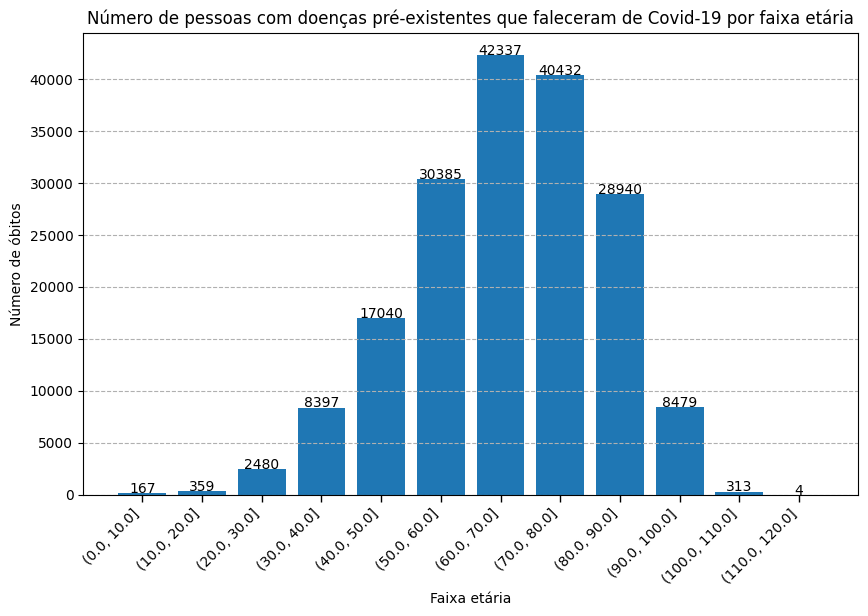

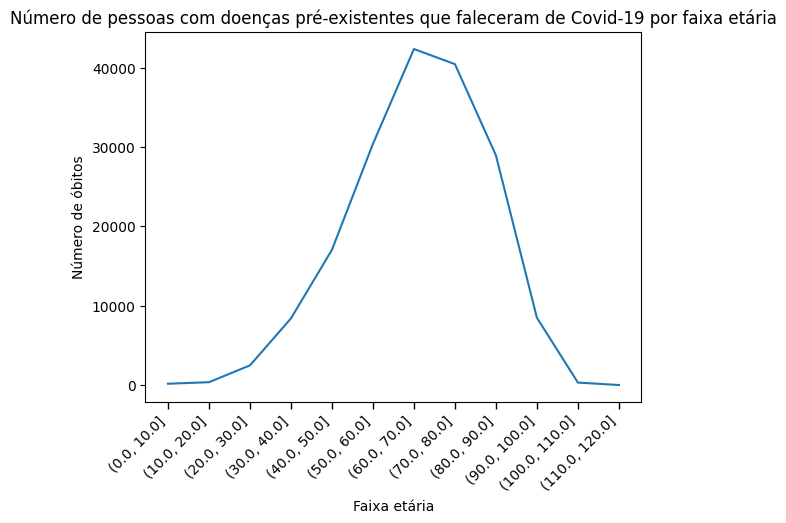

In [17]:
faixas_etarias = np.arange(0, Arquivo['Idade'].max()+10, 10) #Criando as faixas etarias de 0 a 120 de 10 em 10
Arquivo['faixa_etaria'] = pd.cut(Arquivo['Idade'], faixas_etarias) #Incluindo ele no dataframe

# Filtrando as linhas onde a coluna "obito" e igual a 1
obitos = Arquivo[Arquivo['Obito'] == 1]

# Contando o numero de pessoas em cada faixa etaria que obteve obito
obitos_por_faixa_etaria = obitos['faixa_etaria'].value_counts().sort_index()

#Plot Grafico
plt.figure(figsize=(10,6)) # Aumentando o tamanho do grafico


plt.bar(obitos_por_faixa_etaria.index.astype(str), obitos_por_faixa_etaria.values, color='#1f77b4') #Grafico em barra Obitos x Faixa Etaria

plt.grid(axis='y', linestyle='--') #Adicionando grade para melhor estetica

# Definindo titulo e rotulos dos eixos x e y
plt.title("Número de pessoas com doenças pré-existentes que faleceram de Covid-19 por faixa etária")
plt.xlabel("Faixa etária")
plt.ylabel("Número de óbitos")

# Ajustando os rotulos do eixo x e os parametros do tick
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tick_params(axis='x', which='major', length=5, width=1, direction='out')

# Adicionando anotacoes para mostrar os valores de cada barra
for i, v in enumerate(obitos_por_faixa_etaria.values):
    plt.text(i, v+10, str(v), ha='center', fontsize=10)

plt.show()

#############################################################################################################
#Plot Grafico
# Criando um grafico de linhas com o numero de obitos por faixa etaria
plt.plot(obitos_por_faixa_etaria.index.astype(str), obitos_por_faixa_etaria.values)
plt.title("Número de pessoas com doenças pré-existentes que faleceram de Covid-19 por faixa etária")
plt.xlabel("Faixa etária")
plt.ylabel("Número de óbitos")

# Ajustando os rotulos do eixo x e os parametros do tick
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tick_params(axis='x', which='major', length=5, width=1, direction='out')

# Exibindo o grafico de linhas
plt.show()





#### Terceiro Exercicio 

Qual a doença pré-existente mais provável de se encontrar numa pessoa com covid?

Aqui podemos ter uma divergencia na analise, por conta dos casos "IGNORADOS", como citado anteriormente, tendo em vista que para ver a doença pré-existente mais provável de se encontrar numa pessoa com covid so precisariamos ver quais contam com mais pessoas que responderam SIM, desconsiderando os ignorados.

Todavia esses podem seguir o mesmo % de respostas entre SIM e NAO, podendo ser considerado como respostas validas, fizemos um segundo print de um grafico para observar se a proporcao se mantem 

A doenca com mais provavel de ser encontrada numa pessoa com covid e: Cardiopatia.


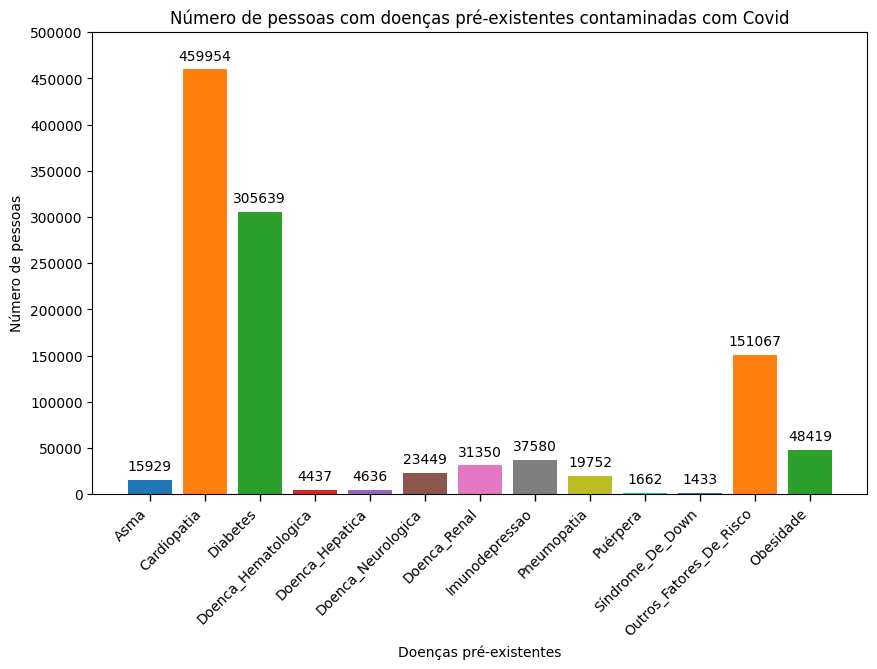

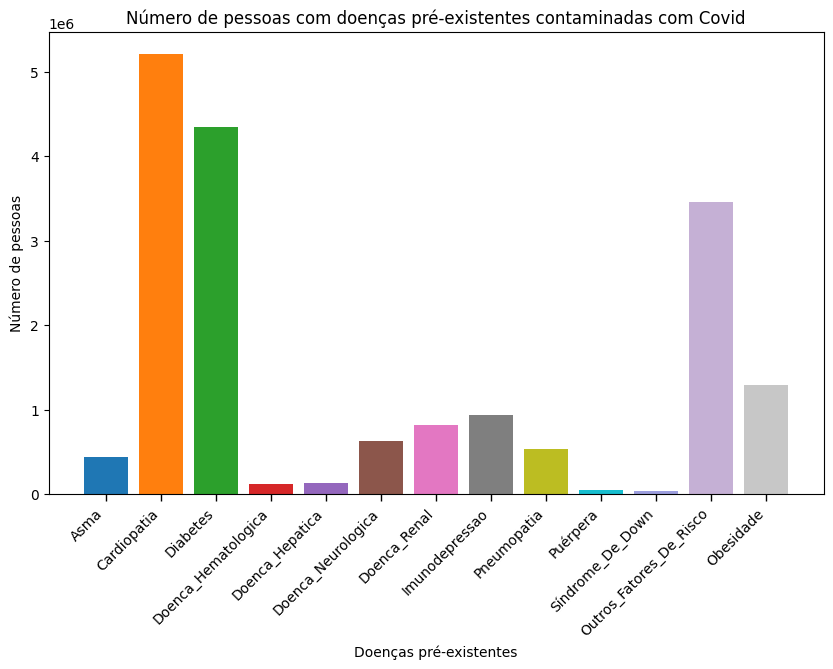

In [18]:
##Contagem do numero de casos de cada doenca
d1 = Arquivo['Asma'].value_counts()["SIM"]
d2 = Arquivo['Cardiopatia'].value_counts()["SIM"]
d3 = Arquivo['Diabetes'].value_counts()["SIM"]
d4 = Arquivo['Doenca_Hematologica'].value_counts()["SIM"]
d5 = Arquivo['Doenca_Hepatica'].value_counts()["SIM"]
d6 = Arquivo['Doenca_Neurologica'].value_counts()["SIM"]
d7 = Arquivo['Doenca_Renal'].value_counts()["SIM"]
d8 = Arquivo['Imunodepressao'].value_counts()["SIM"]
d9 = Arquivo['Pneumopatia'].value_counts()["SIM"]
d10 = Arquivo['Puérpera'].value_counts()["SIM"]
d11 = Arquivo['Síndrome_De_Down'].value_counts()["SIM"]
d12 = Arquivo['Outros_Fatores_De_Risco'].value_counts()["SIM"]
d13 = Arquivo['Obesidade'].value_counts()["SIM"]

#Listas para organizacao e analise dos valores
Lista_Doencas = [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13]
Lista_Nome_Doencas = ["Asma", "Cardiopatia", "Diabetes", "Doenca_Hematologica", "Doenca_Hepatica", "Doenca_Neurologica", "Doenca_Renal", "Imunodepressao", "Pneumopatia", "Puérpera", "Síndrome_De_Down", "Outros_Fatores_De_Risco", "Obesidade"]

maior_numero = max(Lista_Doencas) #Ver qual doenca pre-existente tem maior incidencia nos casos de covid
posicao = Lista_Doencas.index(maior_numero) #Ve a posicao no vetor da doenca para retornar seu nome

print(f"A doenca com mais provavel de ser encontrada numa pessoa com covid e: {Lista_Nome_Doencas[posicao]}.")
#print(f"Com {maior_numero} numero de casos.")  #Print caso queira ver o numero de casos 


#Plot Grafico
# Aumentando o tamanho do gráfico
plt.figure(figsize=(10,6))

# Definindo a cor das barras
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plotando o gráfico de barras com as cores definidas
plt.title("Número de pessoas com doenças pré-existentes contaminadas com Covid")
plt.bar(Lista_Nome_Doencas, Lista_Doencas, color=colors)
plt.xticks(rotation='vertical')
plt.yticks(range(0,500000+50000,50000))
plt.xlabel('Doenças pré-existentes')
plt.ylabel('Número de pessoas')
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis='x', which='major', length=5, width=1, direction='out')

# Adicionando anotações para mostrar os valores de cada barra
for i, v in enumerate(Lista_Doencas):
    plt.text(i, v+10000, str(v), ha='center', fontsize=10)

plt.show()

##################################################################################################################################
## Incluindo os ignorados em sim ou nao seguindo a proporcao para verificar
# lista com as doenças
Lista_Nome_Doencas = ['Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca_Renal', 'Imunodepressao', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco', 'Obesidade']

# dicionário para armazenar as quantidades de SIM
quantidades = {}

# loop para calcular a quantidade de SIM para cada doença
for doenca in Lista_Nome_Doencas:
    # contar a quantidade de SIM, NÃO e IGNORADO para cada doença
    sim = Arquivo[doenca].value_counts()['SIM']
    nao = Arquivo[doenca].value_counts()['NÃO']
    ignorado = Arquivo[doenca].value_counts()['IGNORADO']
    
    # calcular a proporção de SIM e NÃO para cada doença
    proporcao_sim = sim / (sim + nao)
    proporcao_nao = nao / (sim + nao)
    
    # multiplicar o número de IGNORADOS pela proporção correspondente
    ignorado_sim = ignorado * proporcao_sim
    ignorado_nao = ignorado * proporcao_nao
    
    # somar o número de SIM com o resultado obtido no passo anterior
    quantidades[doenca] = sim + ignorado_sim

# define as cores das barras
cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9c9ede', '#c5b0d5', '#c7c7c7']


plt.figure(figsize=(10,6))

plt.bar(quantidades.keys(), quantidades.values(), color=cores) # cria o gráfico de barras

plt.xticks(rotation=90)
plt.xlabel('Doenças pré-existentes')
plt.ylabel('Número de pessoas')
plt.title('Número de pessoas com doenças pré-existentes contaminadas com Covid')
plt.xticks(rotation=45, ha="right")
plt.tick_params(axis='x', which='major', length=5, width=1, direction='out')
plt.show()




#### Quarto Exercicio 

Baseado nesses dados, faça um modelo que estime a probabilidade da pessoa morrer, uma vez que está contaminada com covid, e considerando os inputs de idade, gênero e doenças pré-existentes

Treinamento do modelo

In [7]:
# Load data
data = Arquivo

# Select relevant features and target variable
features = ['Idade', 'Genero', 'Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca_Renal', 'Imunodepressao', 'Obesidade', 'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down']
X = data[features]
y = data['Obito']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate model performance
from sklearn.metrics import roc_auc_score
print("AUC: ", roc_auc_score(y_test, y_pred_prob)) 

d:\Python_Novo\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC:  0.9272614486901485


Input do usuario, conta com mecanismos para corrigir possiveis erros de digitacao.

In [19]:
#Vetor de valores de entrada podendo ser adicionada mais doencas ou outras

#Possiveis entradas de doencas: 'Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca_Renal', 
#                               'Imunodepressao', 'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco', 'Obesidade'

#Possiveis entradas genero: Masulino , Feminino

#Entrada da idade um numero inteiro, nao entrar como string

vetor_entrada = [70, "MAsculino" , "Pneumopatia", "Obesidade"]

In [20]:

#Lista generos possiveis
d_Genero = 0
d_Genero_N = 1


#Lista doencas possiveis
d_Asma = 0
d_Asma_N = 1

d_Cardiopatia = 0
d_Cardiopatia_N = 1

d_Diabetes = 0
d_Diabetes_N = 1

d_Doenca_Hematologica = 0
d_Doenca_Hematologica_N = 1

d_Doenca_Hepatica = 0
d_Doenca_Hepatica_N = 1

d_Doenca_Neurologica = 0
d_Doenca_Neurologica_N = 1

d_Doenca_Renal = 0
d_Doenca_Renal_N = 1

d_Imunodepressao = 0
d_Imunodepressao_N = 1

d_Pneumopatia = 0
d_Pneumopatia_N = 1

d_Puerpera = 0
d_Puerpera_N = 1

d_Sindrome_De_Down = 0
d_Sindrome_De_Down_N = 1

d_Outros_Fatores_De_Risco = 0
d_Outros_Fatores_De_Risco_N = 1

d_Obesidade = 0
d_Obesidade_N = 1

#Correcao de possiveis erros de input da doenca e correcao para serem aceitos por semelhanca seguindo o algoritimo de fuzz
for word in vetor_entrada:
    if type(word) == int:
        pass
    else:
        similarity_genero = fuzz.ratio(word, "MASCULINO")
        similarity_asma = fuzz.ratio(word, "Asma")
        similarity_cardiopatia = fuzz.ratio(word, "Cardiopatia")
        similarity_diabetes = fuzz.ratio(word, "Diabetes")
        similarity_doenca_hematologica = fuzz.ratio(word, " Hematologica")
        similarity_doenca_hepatica = fuzz.ratio(word, "Hepatica")
        similarity_doenca_neurologica = fuzz.ratio(word, "Neurologica")
        similarity_doenca_renal = fuzz.ratio(word, "Renal")
        similarity_imunodepressao = fuzz.ratio(word, "Imunodepressao")
        similarity_pneumopatia = fuzz.ratio(word, "Pneumopatia")
        similarity_puerpera = fuzz.ratio(word, "Puérpera")
        similarity_sindrome_de_down = fuzz.ratio(word, "Síndrome De Down")
        similarity_outros_fatores_de_risco = fuzz.ratio(word, "Outros")
        similarity_obesidade = fuzz.ratio(word, "Obesidade")
    
        if similarity_genero >= 60:
            d_Genero = 1
            d_Genero_N = 0

        if similarity_asma >= 60:
            d_Asma = 1
            d_Asma_N = 0
        if similarity_cardiopatia >= 60:
            d_Cardiopatia = 1
            d_Cardiopatia_N = 0
        if similarity_diabetes >= 60:
            d_Diabetes = 1
            d_Diabetes_N = 0
        if similarity_doenca_hematologica >= 60:
            d_Doenca_Hematologica = 1
            d_Doenca_Hematologica_N = 0
        if similarity_doenca_hepatica >= 60:
            d_Doenca_Hepatica = 1
            d_Doenca_Hepatica_N = 0
        if similarity_doenca_neurologica >= 60:
            d_Doenca_Neurologica = 1
            d_Doenca_Neurologica_N = 0
        if similarity_doenca_renal >= 60:
            d_Doenca_Renal = 1
            d_Doenca_Renal_N = 0
        if similarity_imunodepressao >= 60:
            d_Imunodepressao = 1
            d_Imunodepressao_N = 0
        if similarity_pneumopatia >= 60:
            d_Pneumopatia = 1
            d_Pneumopatia_N = 0
        if similarity_puerpera >= 60:
            d_Puerpera = 1
            d_Puerpera_N = 0
        if similarity_sindrome_de_down >= 60:
            d_Sindrome_de_Down = 1
            d_Sindrome_de_Down_N = 0
        if similarity_outros_fatores_de_risco >= 50:
            d_Outros_Fatores_De_Risco = 1
            d_Outros_Fatores_De_Risco_N = 0
        if similarity_obesidade >= 60:
            d_Obesidade = 1
            d_Obesidade_N = 0


# example input data
data2 = examples = [
    {
      
    'Idade': vetor_entrada[0],
        'Genero_FEMININO': d_Genero_N,
        'Genero_IGNORADO': 0,
        'Genero_INDEFINIDO': 0,
        'Genero_MASCULINO': d_Genero,
        'Asma_IGNORADO': 0,
        'Asma_NÃO': d_Asma_N,
        'Asma_SIM': d_Asma,
        'Cardiopatia_IGNORADO': 0,
        'Cardiopatia_NÃO': d_Cardiopatia_N,
        'Cardiopatia_SIM': d_Cardiopatia,
        'Diabetes_IGNORADO': 0,
        'Diabetes_NÃO': d_Diabetes_N,
        'Diabetes_SIM': d_Diabetes,
        'Doenca_Hematologica_IGNORADO': 0,
        'Doenca_Hematologica_NÃO': d_Doenca_Hematologica_N,
        'Doenca_Hematologica_SIM': d_Doenca_Hematologica,
        'Doenca_Hepatica_IGNORADO': 0,
        'Doenca_Hepatica_NÃO': d_Doenca_Hepatica_N,
        'Doenca_Hepatica_SIM': d_Doenca_Hepatica,
        'Doenca_Neurologica_IGNORADO': 0,
        'Doenca_Neurologica_NÃO': d_Doenca_Neurologica_N,
        'Doenca_Neurologica_SIM': d_Doenca_Neurologica,
        'Doenca_Renal_IGNORADO': 0,
        'Doenca_Renal_NÃO': d_Doenca_Renal_N,
        'Doenca_Renal_SIM': d_Doenca_Renal,
        'Imunodepressao_IGNORADO': 0,
        'Imunodepressao_NÃO': d_Imunodepressao_N,
        'Imunodepressao_SIM': d_Imunodepressao,
        'Obesidade_IGNORADO': 0,
        'Obesidade_NÃO': d_Obesidade_N,
        'Obesidade_SIM': d_Obesidade,
        'Outros_Fatores_De_Risco_IGNORADO': 0,
        'Outros_Fatores_De_Risco_NÃO': d_Outros_Fatores_De_Risco_N,
        'Outros_Fatores_De_Risco_SIM': d_Outros_Fatores_De_Risco,
        'Pneumopatia_IGNORADO': 0,
        'Pneumopatia_NÃO': d_Pneumopatia_N,
        'Pneumopatia_SIM': d_Pneumopatia,
        'Puérpera_IGNORADO': 0,
        'Puérpera_NÃO': d_Puerpera_N,
        'Puérpera_SIM': d_Puerpera,
        'Síndrome_De_Down_IGNORADO': 0,
        'Síndrome_De_Down_NÃO': d_Sindrome_De_Down_N,
        'Síndrome_De_Down_SIM': d_Sindrome_De_Down
    }
    # add more examples here
]

# create DataFrame from input data
df2 = pd.DataFrame(data2)

# apply one-hot encoding to 'genero' column
probabilidade = model.predict_proba(df2)[0][1]
print(f"A probabilidade da pessoa vir a obito com essas caracteristicas e de {(probabilidade*100).round(2)}%")

A probabilidade da pessoa vir a obito com essas caracteristicas e de 78.15%
